In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
import seaborn as sns
sns.set()

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
from src.data.read_dataset import read_all_csvs

In [2]:
df = read_all_csvs("../data/raw/")
print(df.shape)
df.head()

(53830, 26)


,label,sensor_id,file,year,month,day,hour,min,sec,humidity,temperature,luminosity,altitude,air_pressure,wbf,complexity,peaks_freq_1,peaks_freq_2,peaks_freq_3,peaks_freq_4,peaks_freq_5,peaks_freq_6,inharmonicity,rho,rho_wbf,training
0,1,S-ISCA,S-ISCA_C1_Aedes female-17-07-2017_1/009/263.wav,2017,7,16,1,29,31,82.2,32.2,0,283.8,98071.2,630.000000,0.101088,640.031362,174.882867,1285.605760,1901.109791,2498.769171,903.692371,852.170248,1.136137,715.766406,1.0
1,1,S-ISCA,S-ISCA_C2_Ae. aegypti Females 1/030/409.wav,2017,8,2,0,18,7,77.9,32.0,0,280.5,98108.3,531.325301,0.224806,555.793009,1112.718004,1637.186246,214.635467,132.680029,2151.962637,813.111519,1.138392,604.856552,1.0
2,1,S-ISCA,S-ISCA_C1_Aedes female-17-07-2017_1/009/334.wav,2017,7,16,4,14,19,82.9,32.2,0,289.6,98005.8,604.109589,0.219285,602.585260,1206.034901,1808.189594,169.315181,1039.594139,2501.189893,837.291757,1.135223,685.799085,1.0
3,1,S-ISCA,S-ISCA_C2_Ae. aegypti Females 1/017/017.wav,2017,7,28,18,38,39,74.9,32.7,6,289.5,98006.9,658.208955,0.061065,603.204472,171.281104,393.432048,1245.686466,1376.720576,1725.602073,616.744760,1.134593,746.799573,1.0
4,1,S-ISCA,S-ISCA_C2_Ae. aegypti Females 1/034/252.wav,2017,8,4,21,17,4,76.7,32.4,0,279.9,98115.8,495.505618,0.240299,512.479779,91.419255,991.708437,1504.997734,302.777490,1936.867124,722.437621,1.136877,563.329010,1.0


# Map label to 0 or 1.

Since we already have 1 in our label, we map "3" to 0 for simplicity

In [3]:
df.loc[df["label"] != 1, "label"] = 0

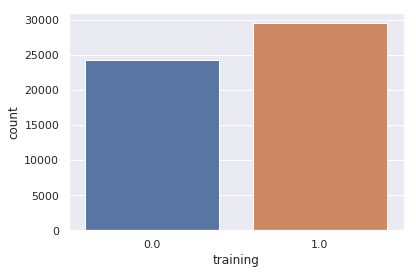

In [4]:
sns.countplot(df["training"])

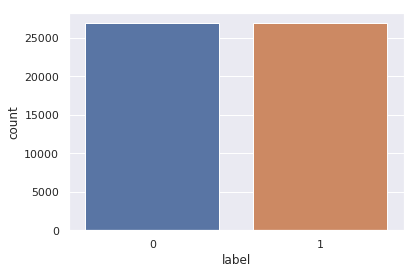

In [5]:
sns.countplot(df["label"])

In [6]:
train_idx = df["training"] == 1
print(sum(train_idx), sum(~train_idx))
skip_cols = ['label', 'sensor_id', 'file', 'year', 'month', 
             'day', 'hour', 'min', 'sec', 'training']
train_cols = list(filter(lambda x: x not in skip_cols, df.columns))

x_train = df.loc[train_idx, train_cols]
y_train = df.loc[train_idx, "label"]

x_test = df.loc[~train_idx, train_cols]
y_test = df.loc[~train_idx, "label"]

print(x_train.shape, x_test.shape)

29520 24310
(29520, 16) (24310, 16)


In [7]:
import time as time
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier

def train_model(X, X_test, y, folds, params=None, model_type='lgb', 
                plot_feature_importance=False, cols_drop=[], 
                n_jobs=10, stratified=None, n_estimators=100,
               verbose=True, return_model=False, pandas=False, return_auc=False):
    # Multipurpose training function
    # Taken from: https://www.kaggle.com/artgor/elo-eda-and-models
    oof = np.zeros(X.shape[0])
    prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()
    
    if stratified is not None:
        tuples = folds.split(X, stratified)
    elif return_model:
        tuples =  [(np.arange(X.shape[0]), np.arange(X.shape[0]))]
    else:
        tuples = folds.split(X)
        
    n_fold = 0
    for fold_n, (train_index, valid_index) in enumerate(tuples):
        n_fold += 1
        if verbose: 
            print('Fold', fold_n, 'started at', time.ctime())
        if pandas:
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        else:
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        """
        # Process our train/valid/test considering this fold only
        X_train.drop(columns=cols_drop, inplace=True)
        X_valid.drop(columns=cols_drop, inplace=True)
        X_test.drop(columns=[x for x in cols_drop if x != 'target'], inplace=True)
        """ 
        # XGBoost
        if model_type == 'xgb':
            """XGBoost version
            """
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)
            test_data = xgb.DMatrix(data=X_test)
            watchlist = [(valid_data, 'eval'), (train_data, 'train')]
            model = xgb.train(params, train_data, n_estimators,
                          evals=watchlist,
                          verbose_eval=True)
            # Sklearn version
            """
            model = XGBClassifier(**params)
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=True)
            """
            
            y_pred_valid = model.predict(valid_data, 
                                               ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(test_data, 
                                         ntree_limit=model.best_ntree_limit)
            
            y_pred_valid = y_pred_valid.round()
            y_pred = y_pred.round()
        
        oof[valid_index] = y_pred_valid#.reshape(-1,)
        scores.append(accuracy_score(y_valid, y_pred_valid))
        prediction += y_pred    
        score = accuracy_score(y_valid, y_pred_valid)
        if verbose:
            print(f'Fold {fold_n}. AUC: {score:.4f}.')
            
    #print(n_fold)
    prediction /= n_fold
    
    if verbose:
        print('Folding finished at', time.ctime())
        print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if return_model:
        return oof, prediction, model
    elif return_auc:
        return oof, prediction, np.mean(scores)
    else:
        return oof, prediction


In [8]:
xgb_params = {'eval_metric': 'error', 'silent': False, 'nthread': -1,
             'objective': 'binary:logistic', }
# RUN
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=11)
oof_xgb, prediction_xgb, model = train_model(x_train, x_test, y_train,
                                        folds, 
                                      params=xgb_params, model_type='xgb', 
                                     stratified=y_train, pandas=True,
                                     verbose=True, return_model=True)

Fold 0 started at Mon Sep 30 14:38:39 2019
[0]	eval-error:0.001186	train-error:0.001397
[1]	eval-error:0.001016	train-error:0.001313
[2]	eval-error:0.001016	train-error:0.001313
[3]	eval-error:0.000847	train-error:0.000974
[4]	eval-error:0.001186	train-error:0.000974
[5]	eval-error:0.000339	train-error:0.000847
[6]	eval-error:0.000508	train-error:0.000847
[7]	eval-error:0.000508	train-error:0.00072
[8]	eval-error:0.000508	train-error:0.00072
[9]	eval-error:0.000678	train-error:0.000508
[10]	eval-error:0.000339	train-error:0.000381
[11]	eval-error:0.000339	train-error:0.000169
[12]	eval-error:0.000339	train-error:0.000169
[13]	eval-error:0.000339	train-error:0.000127
[14]	eval-error:0.000339	train-error:0.000127
[15]	eval-error:0.000169	train-error:0.000127
[16]	eval-error:0.000339	train-error:8.5e-05
[17]	eval-error:0.000339	train-error:8.5e-05
[18]	eval-error:0.000169	train-error:4.2e-05
[19]	eval-error:0.000169	train-error:4.2e-05
[20]	eval-error:0.000169	train-error:4.2e-05
[21]	eva

Fold 2 started at Mon Sep 30 14:38:43 2019
[0]	eval-error:0.001186	train-error:0.001228
[1]	eval-error:0.001186	train-error:0.001228
[2]	eval-error:0.001186	train-error:0.001228
[3]	eval-error:0.001016	train-error:0.000762
[4]	eval-error:0.001524	train-error:0.001016
[5]	eval-error:0.001016	train-error:0.000678
[6]	eval-error:0.000847	train-error:0.00055
[7]	eval-error:0.000847	train-error:0.00055
[8]	eval-error:0.000847	train-error:0.00055
[9]	eval-error:0.000847	train-error:0.000381
[10]	eval-error:0.000847	train-error:0.000212
[11]	eval-error:0.000678	train-error:8.5e-05
[12]	eval-error:0.000678	train-error:8.5e-05
[13]	eval-error:0.000678	train-error:8.5e-05
[14]	eval-error:0.000678	train-error:8.5e-05
[15]	eval-error:0.000678	train-error:4.2e-05
[16]	eval-error:0.000678	train-error:4.2e-05
[17]	eval-error:0.000678	train-error:4.2e-05
[18]	eval-error:0.000678	train-error:4.2e-05
[19]	eval-error:0.000678	train-error:0
[20]	eval-error:0.000508	train-error:0
[21]	eval-error:0.000339	t

[0]	eval-error:0.001355	train-error:0.001016
[1]	eval-error:0.001355	train-error:0.000974
[2]	eval-error:0.001355	train-error:0.001059
[3]	eval-error:0.001355	train-error:0.000974
[4]	eval-error:0.001355	train-error:0.000974
[5]	eval-error:0.001016	train-error:0.00055
[6]	eval-error:0.001016	train-error:0.000508
[7]	eval-error:0.001016	train-error:0.000508
[8]	eval-error:0.001016	train-error:0.000508
[9]	eval-error:0.001016	train-error:0.000508
[10]	eval-error:0.001016	train-error:0.000381
[11]	eval-error:0.001016	train-error:0.000254
[12]	eval-error:0.001016	train-error:0.000296
[13]	eval-error:0.000847	train-error:0.000212
[14]	eval-error:0.000678	train-error:0.000169
[15]	eval-error:0.000678	train-error:0.000127
[16]	eval-error:0.000678	train-error:0.000127
[17]	eval-error:0.000678	train-error:8.5e-05
[18]	eval-error:0.000678	train-error:8.5e-05
[19]	eval-error:0.000678	train-error:8.5e-05
[20]	eval-error:0.000678	train-error:4.2e-05
[21]	eval-error:0.000678	train-error:4.2e-05
[22]

In [10]:
accuracy_score(y_test, prediction_xgb.round())

0.851090086384204

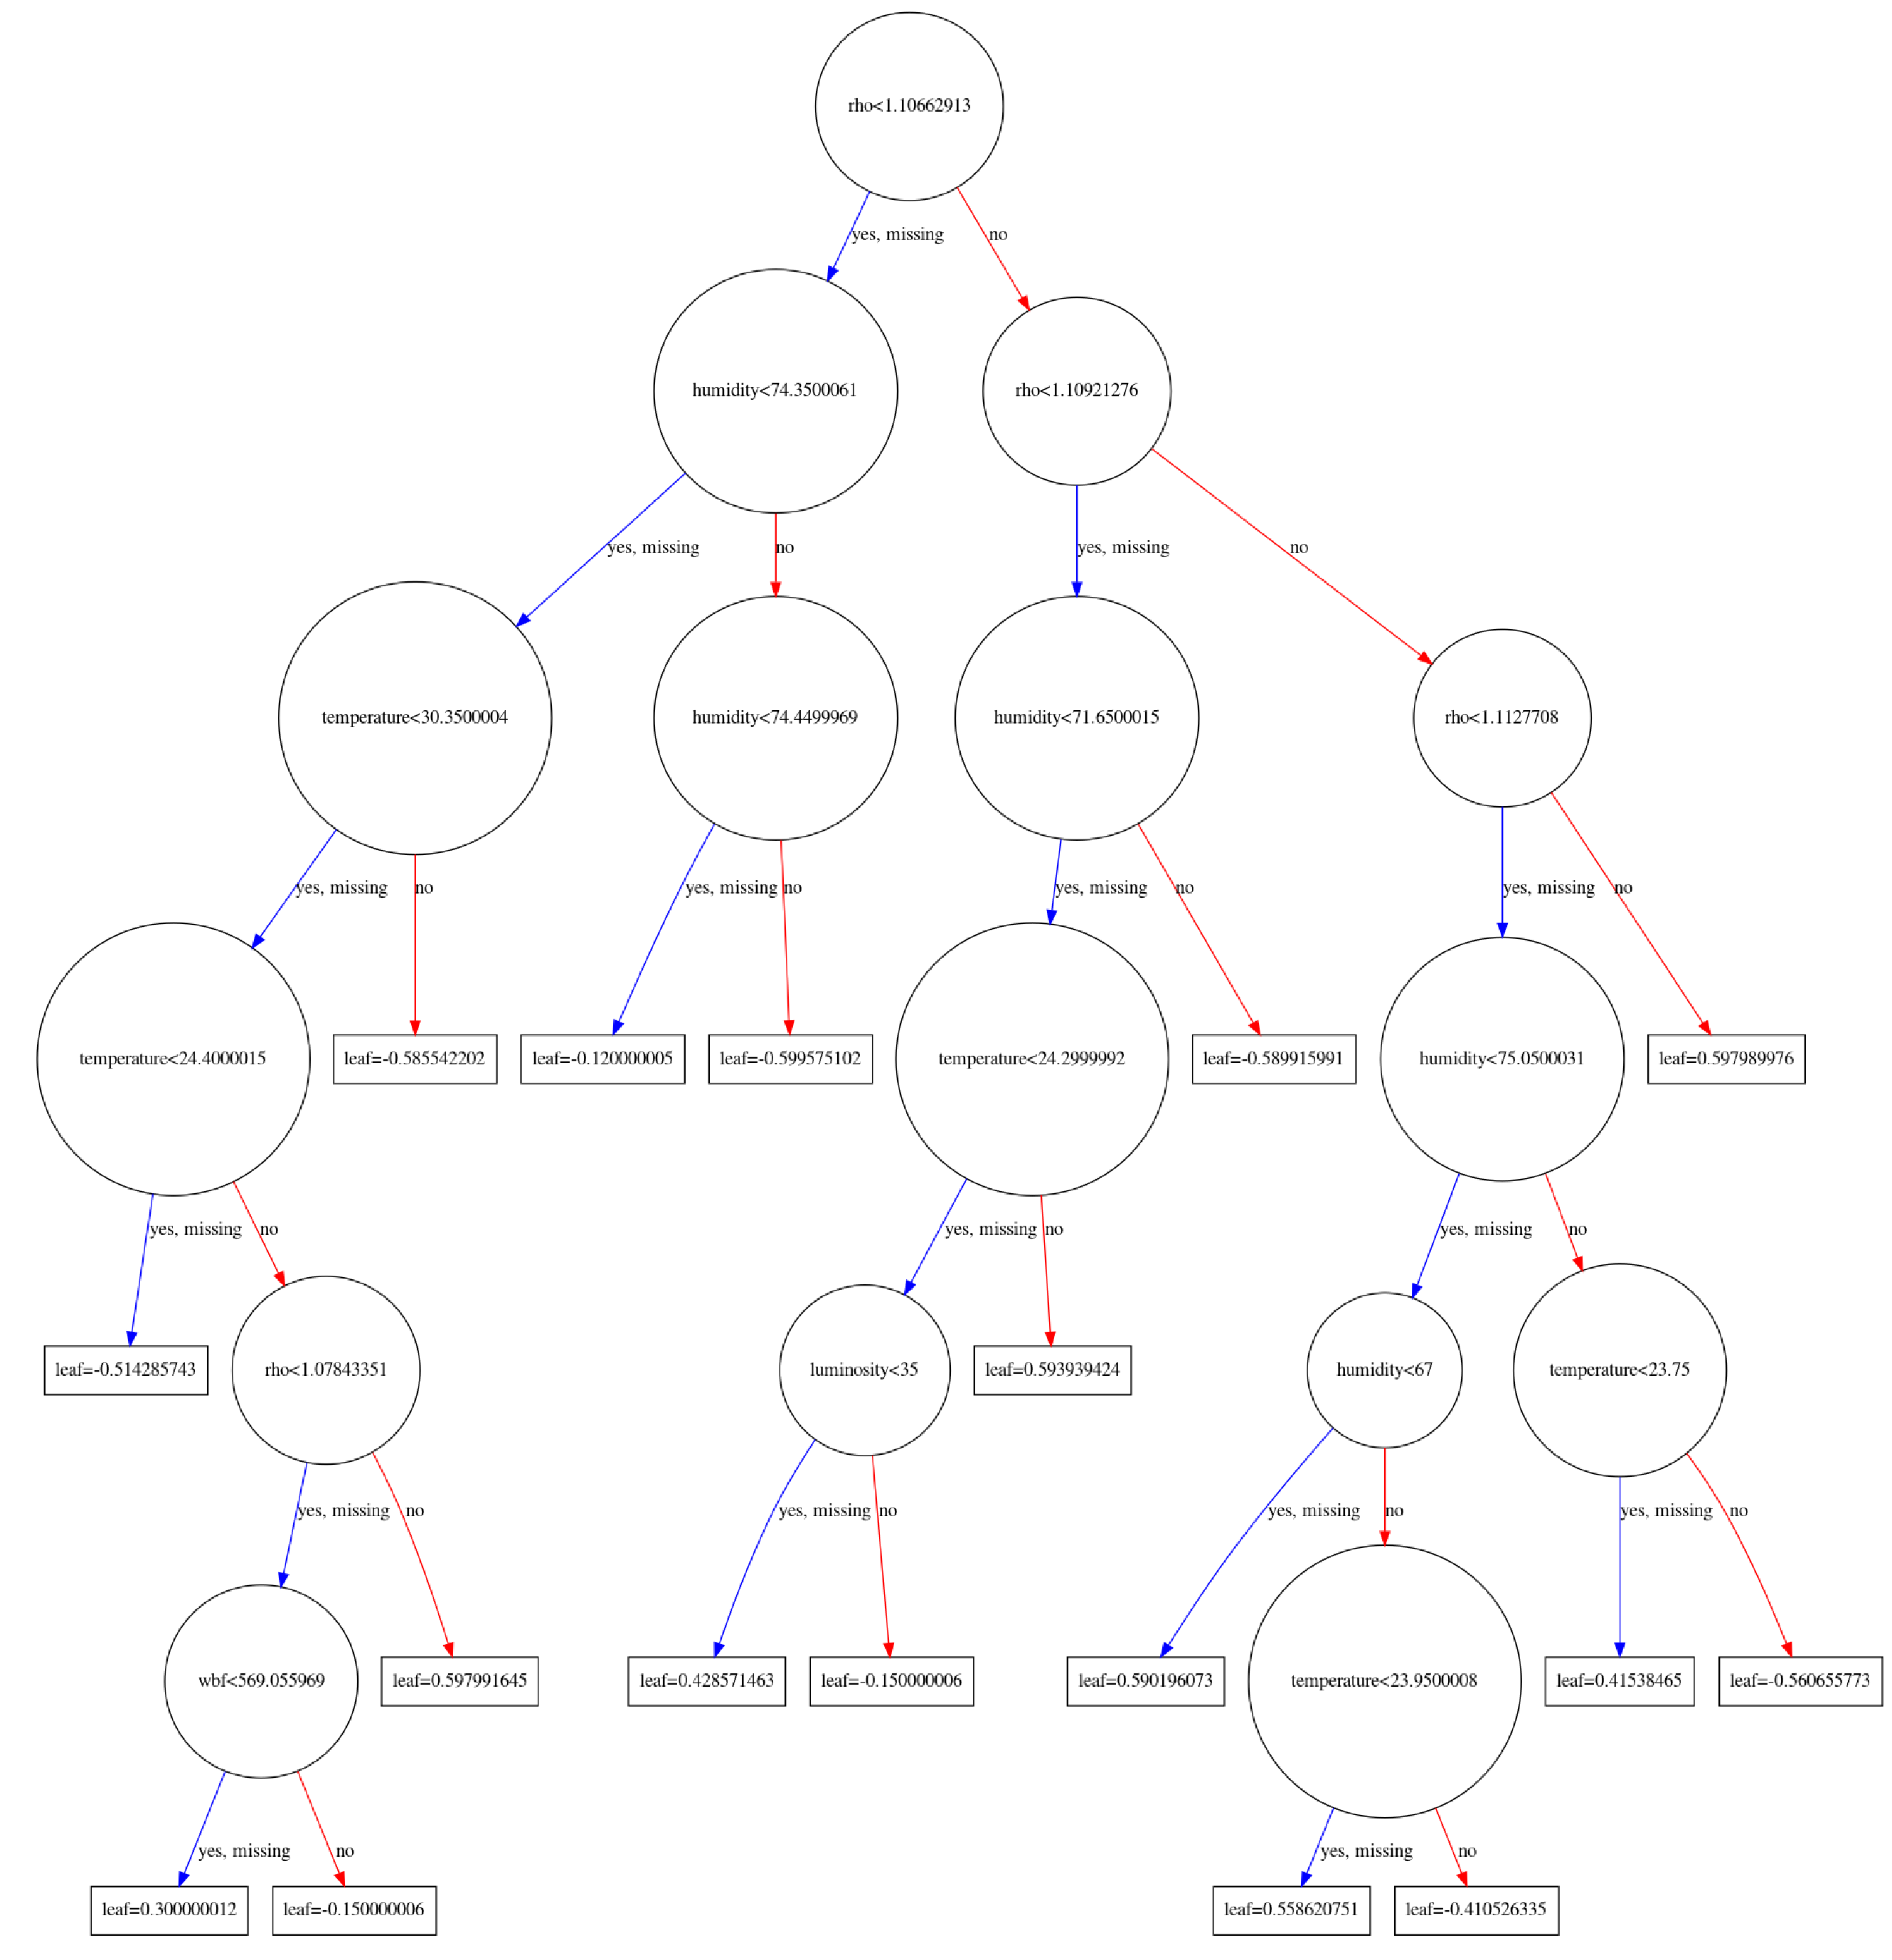

In [13]:
from xgboost import plot_tree
##set up the parameters
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 80,50

plot_tree(model, num_trees=0)

In [25]:
preds = model.predict(xgb.DMatrix(x_test), ntree_limit=1)
accuracy_score(y_test, preds.round())

0.7919374742904155

In [26]:
preds = model.predict(xgb.DMatrix(x_train), ntree_limit=1)
accuracy_score(y_train, preds.round())

0.9989159891598915